In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json

In [2]:
df = pd.read_pickle("citibikedata/9000timeslots.pickle")
# Please note that some unused columns were deleted.
# However, in all other respects the pickled data was "raw".
# Row cleaning had not yet taken place.

In [3]:
STATIONDB = pd.read_pickle("citibikedata/ALLSTATIONS.pickle")

In [4]:
TARGETSTATION = 465   # Happens to be my favorite TimesSq station on 41st.

In [5]:
df.dtypes

is_installed           int32
is_renting             int32
is_returning           int32
last_reported          int32
num_bikes_available    int32
num_bikes_disabled     int32
num_docks_available    int32
num_docks_disabled     int32
station_id             int32
ts                     int64
dtype: object

In [6]:
# Houston we have a problem!
# We are getting files with "last_reported" of ZERO so those must be filtered out of the dataframe first.
df = df[df['last_reported'] > 1000]

In [7]:
# OK now the df is clean of bad timestamps in the "last_reported" column.
# Converting from typical second-granularity epoch timestamp requires unit='s'
df['most_recent_conn_DT'] = pd.to_datetime(df['last_reported'], unit='s')

In [8]:
# The shape of a dataframe is its row count x column count
df.dtypes

is_installed                    int32
is_renting                      int32
is_returning                    int32
last_reported                   int32
num_bikes_available             int32
num_bikes_disabled              int32
num_docks_available             int32
num_docks_disabled              int32
station_id                      int32
ts                              int64
most_recent_conn_DT    datetime64[ns]
dtype: object

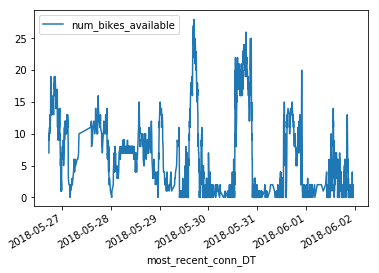

In [9]:
#A successful plotting of just one station:
df[df['station_id']==TARGETSTATION].plot(x='most_recent_conn_DT', y=['num_bikes_available'])

# 1: STATIONS WITH MOST "volatility"

Every station sends its reports to HQ only sporadically, not on a fixed schedule.

So as a quick measure of volatility of station S, we could take the time-sorted signatures for station S, and determine the velocity between each adjacent pair S[i] and S[i+1], and compute the sum of the velocities.

The velocity could simply be the sum, across all columns C, of abs(S[i][c] - S[i+1][c]).  The will as desired produce a velocity of zero if two adjacent reports actually had no net change to report.

We could mute the velocity by the duration between S[i] and S[i+1] but this isn't really necessary since max(i) itself will be higher for the highest-active stations anyway, so they will naturally have more velocities being summed.

## 1.1:  "QuickVolatility"

The quickest approach to computing volatility would be to simply produce the count of individual report rows per station.  There is already a great deal
of spread on that particular metric.

Let's compute a histogram based on QuickVolatility!


In [10]:
df = df.drop(columns=['is_installed','is_renting','is_returning','ts'], 
             errors='ignore')

In [11]:
df.dtypes

last_reported                   int32
num_bikes_available             int32
num_bikes_disabled              int32
num_docks_available             int32
num_docks_disabled              int32
station_id                      int32
most_recent_conn_DT    datetime64[ns]
dtype: object

In [12]:
df.shape

(7247553, 7)

In [13]:
df = df.drop_duplicates()

In [14]:
df.shape

(639047, 7)

In [15]:
df.sort_values(by=['station_id','most_recent_conn_DT'], inplace=True)

In [16]:
# This will create an obj of type DataFrameGroupBy
per_station_info = df.groupby('station_id')

In [17]:
# OK so there are 845 actual listed stations in the official station DB.
# But not all are online as you can see here:
per_station_info.ngroups

807

In [18]:
STATIONDB.index

Int64Index([ 285,  301,  307,  312,  358,  382,  432,  438,  487,  532,
            ...
            3776, 3777, 3778, 3779, 3781, 3782, 3787, 3788, 3790, 3791],
           dtype='int64', name='station_id', length=845)

In [27]:
STATIONDB.loc[72]

capacity                                                                         55
eightd_has_key_dispenser                                                      False
eightd_station_services                                                         NaN
electric_bike_surcharge_waiver                                                False
external_id                                    66db237e-0aca-11e7-82f6-3863bb44ef7c
has_kiosk                                                                      True
lat                                                                         40.7673
lon                                                                        -73.9939
name                                                               W 52 St & 11 Ave
region_id                                                                        71
rental_methods                                                    [CREDITCARD, KEY]
rental_url                        http://app.citibikenyc.com/S6Lr/IBV092JufD

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea41189860>]], dtype=object)

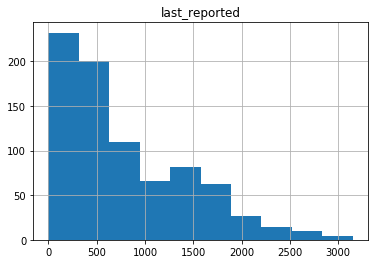

In [19]:
# TRIVIAL  "QuickVolatility" is just the count per station.
per_station_info.count().hist(column='last_reported',bins=10)

In [20]:
# What are the top 20 stations in QuickVolatility?
df_station_to_quickvol = per_station_info.count()

In [38]:
df_station_to_quickvol = df_station_to_quickvol.sort_values(by='last_reported', ascending=False)[:20]

In [41]:
# BRING IN THE STATION PARTICULARS (lat, long, station name)
# This join should not be done more than once; re-join fails.
# df_station_to_quickvol.join(STATIONDB)

In [50]:
topstation = df_station_to_quickvol.iloc[0]
type(df_station_to_quickvol['lat']

TypeError: 'type' object is not subscriptable

In [51]:
from credentials import GOOMAPSAPIKEY

Let's find out exactly how much data we have.  The granularity is per minute, but what is the range?


In [52]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap

output_file("nyc_gmaps.html")

map_options = GMapOptions(lat=topstation['lat'],
                          lng=topstation['lon'], map_type="roadmap", zoom=11)

# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
# Replace the value below with your personal API key:
p = gmap(GOOMAPSAPIKEY, map_options, title="Most Active CitiBike Stations")

source = ColumnDataSource(
    data=dict(lat=df_station_to_quickvol['lat'],
              lon=df_station_to_quickvol['lon'])
)

p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

show(p)